In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_recall_curve, 
    precision_score, recall_score, f1_score, confusion_matrix, roc_curve, average_precision_score
)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from tqdm import tqdm


import json
import yaml
import random
import wandb
import ast
import optuna

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [4]:
def load_ptb_data():
    # PTB-XL 데이터셋 로드 및 전처리
    df_ptb = pd.read_csv('./ptb_xl_data/ptbxl_database.csv', index_col='ecg_id')
    df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: ast.literal_eval(x))
    df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: list(x.keys()))
    df_ptb['label'] = df_ptb.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)
    # 총 21799개 중 AFIB 라벨이 있는 샘플은 1514개로 6.95%에 해당, 샘플 불균형 존재

    labels = df_ptb['label'].values
    lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


    # 데이터 정규화 (전체)
    lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)

    # 데이터셋을 텐서로 변환
    X = torch.Tensor(lead1_signals_normalized)
    y = torch.Tensor(labels).long()

    # 데이터 분할 (훈련:검증:테스트 = 8:1:1)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # 채널 수를 1로 추가
    X_train = X_train.unsqueeze(1)
    X_val = X_val.unsqueeze(1)
    X_test = X_test.unsqueeze(1)

    return X_train, X_val, X_test, y_train, y_val, y_test



def create_dataloaders(batch_size=64):
    # DataLoader 생성, batch_size를 변경하려면 함수 호출 시 파라미터 변경
    X_train, X_val, X_test, y_train, y_val, y_test = load_ptb_data()

    # DataLoader 생성
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    return train_loader, val_loader, test_loader



def load_sph_data(batch_size=64):
    # SPH 데이터 로드 및 전처리
    df_sph = pd.read_csv("./sph_data/metadata.csv", index_col='ECG_ID')
    # 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
    def check_contains_50(code):
        numbers = code.replace(' ', '').replace('+', ';').split(';')
        return '50' in numbers

    df_sph['label'] = df_sph['AHA_Code'].apply(check_contains_50).astype(int)
    
    sph_labels = df_sph['label'].values

    sph_signals = np.load('./custom_file/annie_sph_lead1.npy')
    sph_signals_float = sph_signals.astype(np.float32)
    mean = np.mean(sph_signals_float)
    std = np.std(sph_signals_float)
    sph_signals_normalized = (sph_signals_float - mean) / (std + 1e-7)


    # 데이터 정규화 및 텐서 변환
    X_sph = torch.Tensor(sph_signals_normalized)
    y_sph = torch.Tensor(df_sph['label'].values).long()

    X_sph = X_sph.unsqueeze(1)

    sph_data = TensorDataset(X_sph, y_sph)
    sph_loader = DataLoader(sph_data, batch_size=batch_size)

    return sph_loader



# 1D CNN Modeling

In [5]:
# SimpleCNN

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=2) 
        self.pool = nn.MaxPool1d(kernel_size=5, stride=1) 
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5) 
        self.fc1 = nn.Linear(64 * 2486, 1000) 
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 1)

    def forward(self, x):
        x = self.pool(nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(nn.functional.leaky_relu(self.conv2(x)))
        x = x.view(-1, 64 * 2486)
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x



# 충원님 코드

class Custom1DCNN(nn.Module):
    def __init__(self):
        super(Custom1DCNN, self).__init__()

        # Convolutional Blocks
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 32, kernel_size=5)
        self.maxpool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5)
        self.maxpool3 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(64, 64, kernel_size=5)
        self.maxpool4 = nn.MaxPool1d(2)

        self.conv5 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool5 = nn.MaxPool1d(2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5)
        self.maxpool6 = nn.MaxPool1d(2)

        self.dropout1 = nn.Dropout(0.5)

        self.conv7 = nn.Conv1d(128, 256, kernel_size=5)
        self.maxpool7 = nn.MaxPool1d(2)

        self.conv8 = nn.Conv1d(256, 256, kernel_size=5)
        self.maxpool8 = nn.MaxPool1d(2)

        self.dropout2 = nn.Dropout(0.5)

        self.conv9 = nn.Conv1d(256, 512, kernel_size=5)
        self.maxpool9 = nn.MaxPool1d(2)

        self.dropout3 = nn.Dropout(0.5)

        self.conv10 = nn.Conv1d(512, 512, kernel_size=5)

        # Fully Connected Blocks
        self.flatten = nn.Flatten()

        self.dense1 = nn.Linear(512, 128)
        self.batch_norm_dense1 = nn.BatchNorm1d(128)  # BatchNorm1d for Dense1
        self.dropout4 = nn.Dropout(0.5)

        self.dense2 = nn.Linear(128, 32)
        self.batch_norm_dense2 = nn.BatchNorm1d(32)  # BatchNorm1d for Dense2

        self.dense3 = nn.Linear(32, 1)
        

    def forward(self, x):
        # Convolutional Blocks
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.conv2(x)))
        x = self.maxpool3(self.relu(self.conv3(x)))
        x = self.maxpool4(self.relu(self.conv4(x)))
        x = self.maxpool5(self.relu(self.conv5(x)))
        x = self.maxpool6(self.relu(self.conv6(x)))
        x = self.dropout1(x)
        x = self.maxpool7(self.relu(self.conv7(x)))
        x = self.maxpool8(self.relu(self.conv8(x)))
        x = self.dropout2(x)
        x = self.maxpool9(self.relu(self.conv9(x)))
        x = self.dropout3(x)
        x = self.conv10(x)

        # Fully Connected Blocks
        x = self.flatten(x)
        x = self.dropout4(self.relu(self.batch_norm_dense1(self.dense1(x))))
        x = self.relu(self.batch_norm_dense2(self.dense2(x)))
        x = self.dense3(x)

        return x

# 1D CNN + LSTM Modeling

In [6]:

class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        
        # 첫번째 Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=50, stride=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=20, stride=2)
        self.dropout1 = nn.Dropout(p=0.1)

        # 두번째 Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=10, stride=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=10, stride=2)
        self.dropout2 = nn.Dropout(p=0.1)

        # 세번째 Convolutional Block
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, stride=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.dropout3 = nn.Dropout(p=0.1)

        # LSTM Block
        self.lstm = nn.LSTM(input_size=16, hidden_size=32, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.1)

        # Dense Layers
        self.dense1 = nn.Linear(32, 32)
        self.relu_dense1 = nn.ReLU()
        self.dropout_dense1 = nn.Dropout(p=0.1)

        self.dense2 = nn.Linear(32, 16)
        self.relu_dense2 = nn.ReLU()

        # Output Layer - 이중분류를 위해 출력 유닛을 1로 설정
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        # x: ECG 데이터 (Batch Size, Channels, Length)
        
        # Convolutional Blocks
        x = self.dropout1(self.maxpool1(self.relu1(self.conv1(x))))
        x = self.dropout2(self.maxpool2(self.relu2(self.conv2(x))))
        x = self.dropout3(self.maxpool3(self.relu3(self.conv3(x))))

        # print(x.shape) # (32, 16, 591)

        # LSTM Layer - LSTM은 추가적인 차원을 요구하기 때문에 차원 조정이 필요합니다.
        x = x.permute(0, 2, 1) # (Batch Size, Sequence Length, Features)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout_lstm(x[:, -1, :]) # 마지막 시퀀스의 출력만 사용

        # Dense Layers
        x = self.dropout_dense1(self.relu_dense1(self.dense1(x)))
        x = self.relu_dense2(self.dense2(x))

        # Output Layer - 시그모이드 활성화 함수를 사용하여 0과 1 사이의 값을 출력
        x = torch.sigmoid(self.output(x))
        return x


In [6]:
class SimplifiedCNNLSTMModel(nn.Module):
    def __init__(self):
        super(SimplifiedCNNLSTMModel, self).__init__()
        
        # 첫번째 Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.1)

        # 두번째 Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.1)

        # LSTM Block
        self.lstm = nn.LSTM(input_size=16, hidden_size=16, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.1)

        # Dense Layer
        self.dense = nn.Linear(16, 16)
        self.relu_dense = nn.ReLU()

        # Output Layer
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        # Convolutional Blocks
        x = self.dropout1(self.maxpool1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.maxpool2(self.relu2(self.bn2(self.conv2(x)))))

        # LSTM Layer
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout_lstm(x[:, -1, :])

        # Dense Layer
        x = self.relu_dense(self.dense(x))

        # Output Layer
        x = torch.sigmoid(self.output(x))
        return x


# Transformer model

In [8]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

from model_utils import PositionalEncoding, SelfAttentionPooling

class TransformerModel(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward, nlayers, n_conv_layers=2, n_class=2, dropout=0.5, dropout_other=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.n_class = n_class
        self.n_conv_layers = n_conv_layers
        self.relu = torch.nn.ReLU()
        self.pos_encoder = PositionalEncoding(d_model, dropout)  # 차원을 d_model로 통일
        self.self_att_pool = SelfAttentionPooling(d_model)
        encoder_layers = TransformerEncoderLayer(d_model=d_model, 
                                                 nhead=nhead, 
                                                 dim_feedforward=dim_feedforward, 
                                                 dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.flatten_layer = torch.nn.Flatten()

        # 이진 분류를 위한 선형 출력 레이어 정의
        self.decoder = nn.Sequential(nn.Linear(d_model, d_model), 
                                     nn.Dropout(dropout_other),
                                     nn.Linear(d_model, d_model), 
                                     nn.Linear(d_model, 64))

        # 최종 출력 레이어에서 시그모이드 함수 사용
        self.fc_out1 = torch.nn.Linear(64, 64)
        self.fc_out2 = torch.nn.Linear(64, 1)  # 이진 분류 문제
        self.sigmoid = torch.nn.Sigmoid()

        # 컨볼루션 레이어와 RRI 레이어 정의
        self.conv_layers = nn.ModuleList([torch.nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=3, stride=1, padding=0) for _ in range(n_conv_layers)])
        self.conv1_rri = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, stride=2)  # RRI 데이터에 적합한 커널 크기와 스트라이드 설정
        self.conv2_rri = torch.nn.Conv1d(in_channels=128, out_channels=d_model, kernel_size=3, stride=2)

        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)
        self.dropout = torch.nn.Dropout(p=0.1)

        self.init_weights()  # 가중치 초기화 메소드 활성화

    def init_weights(self):
        initrange = 0.1
        for conv_layer in self.conv_layers:
            conv_layer.weight.data.uniform_(-initrange, initrange)
            conv_layer.bias.data.zero_()
        self.decoder[0].weight.data.uniform_(-initrange, initrange)
        self.decoder[2].weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src2):
        src = src.view(-1, 1, src.shape[1]) 
        src = self.relu(self.conv_layers[0](src))
        for conv_layer in self.conv_layers[1:]:
            src = self.relu(conv_layer(src))
            src = self.maxpool(src)

        src = self.pos_encoder(src)
        src = src.permute(2, 0, 1)
        output = self.transformer_encoder(src)
        output = output.permute(1, 0, 2)
        output = self.self_att_pool(output)
        logits = self.decoder(output)

        src2 = src2.view(-1, 1, src2.shape[1]) 
        src2 = self.relu(self.conv1_rri(src2))
        src2 = self.relu(self.conv2_rri(src2))

        # 나머지 RRI 처리 및 출력 레이어 코드

        logits = self.sigmoid(self.fc_out2(self.dropout(self.relu(self.fc_out1(logits)))))  # 시그모이드 활성화 함수 적용
        return logits


ModuleNotFoundError: No module named 'model_utils'

# Training

In [7]:
# 사용자 정의 모듈을 임포트합니다.
from annie_data_prep import create_dataloaders, load_sph_data
from annie_cnn_model import SimpleCNN, Custom1DCNN, Custom1DCNNWithBatchNormAndDropout
from annie_cnnlstm_model import CNNLSTMModel



def objective(trial):
    ## 모델 시드 고정 
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 사용하는 경우
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    

    # 옵튜나를 이용한 하이퍼파라미터 제안
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [64, 128])
    num_epochs = trial.suggest_int('num_epochs', 40, 100)  # Epoch 수를 동적으로 선택
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])


    # 모델을 GPU로 옮기기
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNLSTMModel().to(device)


    # 손실 함수 및 옵티마이저 설정
    criterion = nn.BCEWithLogitsLoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 100
    #batch_size = 128
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=10, factor=0.1, verbose=True)
    
    train_loader, val_loader, _ = create_dataloaders(batch_size)
    

    # 하이퍼파라미터 출력
    print("-"*40)
    print(f">>>>> Trial {trial.number+1} Start...<<<<<")
    print("-"*40)
    print(f"[Learning Rate] : {learning_rate}")
    print(f"[Batch Size] : {batch_size}")
    print(f"[Epochs] : {num_epochs}")  # 수정된 부분
    print(f"[Optimizer] : {optimizer}")
    print("-"*23)
    print(">>>>> Let's GO!!! <<<<<")
    print("-"*23)

    #print(f"Hidden Units: {hidden_units}")


    # 학습 및 검증 결과 기록을 위한 사전 선언
    model_info = {}

    # 학습 및 검증 과정에서의 손실과 정확도 기록
    train_losses = []
    train_accuracies = []
    train_aurocs = []  # 훈련 데이터 AUROC 기록을 위한 리스트
    train_auprcs = []  # 훈련 데이터 AUPRC 기록을 위한 리스트
    val_losses = []
    val_accuracies = []
    val_aurocs = []
    val_auprcs = []  # AUPRC 기록을 위한 리스트 추가

    
    #best_auroc = float('-inf')  # 최고 AUROC 기록을 위한 초기값 설정
    best_auprc = float('-inf')  # 최고 AUPRC 기록을 위한 초기값 설정
    best_auprc_info = None  # 최고 AUPRC 값을 가진 모델의 정보를 저장할 변수

    epochs_no_improve = 0
    early_stop = False
    patience = 20

    for epoch in range(num_epochs):
        # 훈련 루프
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Trial {trial.number+1} - Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 그래디언트 초기화

            # 순전파 및 역전파
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_accuracy = accuracy_score(train_targets, np.round(train_preds))
        train_auroc = roc_auc_score(train_targets, train_preds)
        train_auprc = average_precision_score(train_targets, train_preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_aurocs.append(train_auroc)
        train_auprcs.append(train_auprc)
        print(f">>> [Train] AUROC: {train_auroc:.4f} / AUPRC: {train_auprc:.4f}")



        # 검증 루프
        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), labels.float())
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(val_targets, np.round(val_preds))
        val_auroc = roc_auc_score(val_targets, val_preds)
        val_auprc = average_precision_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_aurocs.append(val_auroc)
        val_auprcs.append(val_auprc)

        print(f">>> [Valid] AUROC: {val_auroc:.4f} / AUPRC: {val_auprc:.4f}")


        # 에포크 결과 기록
        epoch_info = {
            'train_loss': train_loss,
            'valid_loss': val_loss,
            'train_accuracy': train_accuracy,  
            'valid_accuracy': val_accuracy,      
            'train_auroc': train_auroc,
            'valid_auroc': val_auroc,
            'train_auprc': train_auprc,        
            'valid_auprc': val_auprc
        }
        model_info[epoch + 1] = epoch_info


        # 스케줄러 업데이트
        scheduler.step(val_auprc)

        # Early Stopping 체크 및 모델 저장
        if val_auprc > best_auprc:
            best_auprc = val_auprc
            epochs_no_improve = 0
            best_auprc_info = epoch_info  # 최고 AUPRC 값을 갱신할 때 정보 저장
            # 최고 성능 모델 저장
            torch.save(model.state_dict(), f'CL_trial_{trial.number+1}_best_model.pth')
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping")
                break
    

        # 전체 학습 과정의 결과를 JSON 파일로 저장
        with open(f'CL_trial_{trial.number+1}_performance.json', 'w') as f:
            json.dump(model_info, f, indent=4)



    # 최고 AUPRC 값을 가진 모델의 정보 출력
    print("-" * 42)
    print(f"< Trial {trial.number+1}'s Best Performance>")
    if best_auprc_info is not None:
        items = list(best_auprc_info.items())
        for i, (key, value) in enumerate(items):
            print(f"[{key}]: {value:.4f}" + (" <- Pick It Up!" if i == len(items) - 1 else ""))

    return best_auprc



In [8]:
# 옵튜나 스터디 객체 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터 출력
best_trial = study.best_trial
best_model_path = f'trial_{best_trial.number+1}_best_model.pth'
best_performance_path = f'trial_{best_trial.number+1}_best_performance.json'

print(f"최고 성능을 보인 시도: {best_trial.number+1}")
print("최적의 하이퍼파라미터: {}".format(study.best_trial.params))

[I 2023-12-14 12:45:49,225] A new study created in memory with name: no-name-3a661b10-586c-4812-8616-fea82af0822c


----------------------------------------
>>>>> Trial 1 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.009675563452177868
[Batch Size] : 64
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.009675563452177868
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 1 - Epoch 1/100 - Training: 100%|██████████| 273/273 [00:10<00:00, 25.66it/s]


>>> [Train] AUROC: 0.4976 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 2/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 33.20it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 3/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 33.12it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 4/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 33.05it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 5/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 6/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 7/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.86it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 8/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.80it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 9/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 10/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 11/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 12/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 9.6756e-04.


Trial 1 - Epoch 13/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.69it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 14/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.85it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 15/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.82it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 16/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 17/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 18/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 19/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 20/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.84it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 1 - Epoch 21/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694


[I 2023-12-14 12:49:01,709] Trial 0 finished with value: 0.06972477064220184 and parameters: {'learning_rate': 0.009675563452177868, 'batch_size': 64, 'num_epochs': 63, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.06972477064220184.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 1's Best Performance>
[train_loss]: 0.6967
[valid_loss]: 0.6931
[train_accuracy]: 0.8884
[valid_accuracy]: 0.9303
[train_auroc]: 0.4976
[valid_auroc]: 0.5000
[train_auprc]: 0.0697
[valid_auprc]: 0.0697 <- Pick It Up!
----------------------------------------
>>>>> Trial 2 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.0036949919016174898
[Batch Size] : 64
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0036949919016174898
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 2 - Epoch 1/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.77it/s]


>>> [Train] AUROC: 0.5006 / AUPRC: 0.0692
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0758


Trial 2 - Epoch 2/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.82it/s]


>>> [Train] AUROC: 0.5019 / AUPRC: 0.0705
>>> [Valid] AUROC: 0.5030 / AUPRC: 0.0726


Trial 2 - Epoch 3/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.83it/s]


>>> [Train] AUROC: 0.5055 / AUPRC: 0.0712
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 4/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.83it/s]


>>> [Train] AUROC: 0.5028 / AUPRC: 0.0706
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 5/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5008 / AUPRC: 0.0700
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 6/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5026 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 7/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.52it/s]


>>> [Train] AUROC: 0.4997 / AUPRC: 0.0704
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 8/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.63it/s]


>>> [Train] AUROC: 0.4974 / AUPRC: 0.0690
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 9/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.65it/s]


>>> [Train] AUROC: 0.5032 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 10/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.81it/s]


>>> [Train] AUROC: 0.5037 / AUPRC: 0.0703
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 11/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.53it/s]


>>> [Train] AUROC: 0.5054 / AUPRC: 0.0703
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 12/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.59it/s]


>>> [Train] AUROC: 0.5009 / AUPRC: 0.0704
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 3.6950e-04.


Trial 2 - Epoch 13/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5053 / AUPRC: 0.0704
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 14/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.56it/s]


>>> [Train] AUROC: 0.5026 / AUPRC: 0.0698
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 15/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.78it/s]


>>> [Train] AUROC: 0.5008 / AUPRC: 0.0706
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 16/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.47it/s]


>>> [Train] AUROC: 0.5013 / AUPRC: 0.0699
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 17/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.36it/s]


>>> [Train] AUROC: 0.5019 / AUPRC: 0.0704
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 18/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.39it/s]


>>> [Train] AUROC: 0.4980 / AUPRC: 0.0691
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 19/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.4985 / AUPRC: 0.0693
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 20/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5004 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 2 - Epoch 21/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5006 / AUPRC: 0.0695


[I 2023-12-14 12:52:06,439] Trial 1 finished with value: 0.07584500241429262 and parameters: {'learning_rate': 0.0036949919016174898, 'batch_size': 64, 'num_epochs': 60, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.07584500241429262.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 2's Best Performance>
[train_loss]: 0.7010
[valid_loss]: 0.6931
[train_accuracy]: 0.5486
[valid_accuracy]: 0.9298
[train_auroc]: 0.5006
[valid_auroc]: 0.5028
[train_auprc]: 0.0692
[valid_auprc]: 0.0758 <- Pick It Up!
----------------------------------------
>>>>> Trial 3 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.0053888582507206064
[Batch Size] : 128
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0053888582507206064
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 3 - Epoch 1/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.45it/s]


>>> [Train] AUROC: 0.4956 / AUPRC: 0.0692
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 2/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.59it/s]


>>> [Train] AUROC: 0.5008 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 3/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.69it/s]


>>> [Train] AUROC: 0.4992 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 4/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.58it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 5/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.52it/s]


>>> [Train] AUROC: 0.4995 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 6/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.64it/s]


>>> [Train] AUROC: 0.4985 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 7/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.52it/s]


>>> [Train] AUROC: 0.5010 / AUPRC: 0.0701
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 8/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.59it/s]


>>> [Train] AUROC: 0.4995 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 9/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.73it/s]


>>> [Train] AUROC: 0.4991 / AUPRC: 0.0702
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 10/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.70it/s]


>>> [Train] AUROC: 0.4990 / AUPRC: 0.0702
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 11/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.59it/s]


>>> [Train] AUROC: 0.4995 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 12/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.64it/s]


>>> [Train] AUROC: 0.4998 / AUPRC: 0.0709
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 5.3889e-04.


Trial 3 - Epoch 13/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.66it/s]


>>> [Train] AUROC: 0.5004 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 14/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.67it/s]


>>> [Train] AUROC: 0.4993 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 15/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.68it/s]


>>> [Train] AUROC: 0.5008 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 16/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.68it/s]


>>> [Train] AUROC: 0.4998 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 17/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.69it/s]


>>> [Train] AUROC: 0.4988 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 18/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.68it/s]


>>> [Train] AUROC: 0.5009 / AUPRC: 0.0701
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 19/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.68it/s]


>>> [Train] AUROC: 0.5004 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 20/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.69it/s]


>>> [Train] AUROC: 0.5003 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 3 - Epoch 21/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.67it/s]


>>> [Train] AUROC: 0.4991 / AUPRC: 0.0694


[I 2023-12-14 12:54:11,505] Trial 2 finished with value: 0.06972477064220184 and parameters: {'learning_rate': 0.0053888582507206064, 'batch_size': 128, 'num_epochs': 76, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.07584500241429262.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 3's Best Performance>
[train_loss]: 0.7047
[valid_loss]: 0.6931
[train_accuracy]: 0.7687
[valid_accuracy]: 0.9303
[train_auroc]: 0.4956
[valid_auroc]: 0.5000
[train_auprc]: 0.0692
[valid_auprc]: 0.0697 <- Pick It Up!
----------------------------------------
>>>>> Trial 4 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.0021524406659397385
[Batch Size] : 128
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0021524406659397385
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 4 - Epoch 1/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.92it/s]


>>> [Train] AUROC: 0.4939 / AUPRC: 0.0683
>>> [Valid] AUROC: 0.4909 / AUPRC: 0.0833


Trial 4 - Epoch 2/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.60it/s]


>>> [Train] AUROC: 0.4997 / AUPRC: 0.0686
>>> [Valid] AUROC: 0.4903 / AUPRC: 0.0815


Trial 4 - Epoch 3/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.38it/s]


>>> [Train] AUROC: 0.5062 / AUPRC: 0.0706
>>> [Valid] AUROC: 0.4897 / AUPRC: 0.0770


Trial 4 - Epoch 4/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.32it/s]


>>> [Train] AUROC: 0.4966 / AUPRC: 0.0687
>>> [Valid] AUROC: 0.5283 / AUPRC: 0.0794


Trial 4 - Epoch 5/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.23it/s]


>>> [Train] AUROC: 0.5115 / AUPRC: 0.0707
>>> [Valid] AUROC: 0.5224 / AUPRC: 0.0788


Trial 4 - Epoch 6/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.53it/s]


>>> [Train] AUROC: 0.5084 / AUPRC: 0.0698
>>> [Valid] AUROC: 0.5026 / AUPRC: 0.0726


Trial 4 - Epoch 7/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.81it/s]


>>> [Train] AUROC: 0.5070 / AUPRC: 0.0706
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0715


Trial 4 - Epoch 8/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.62it/s]


>>> [Train] AUROC: 0.5001 / AUPRC: 0.0719
>>> [Valid] AUROC: 0.5274 / AUPRC: 0.0750


Trial 4 - Epoch 9/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.62it/s]


>>> [Train] AUROC: 0.5104 / AUPRC: 0.0716
>>> [Valid] AUROC: 0.5021 / AUPRC: 0.0704


Trial 4 - Epoch 10/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.46it/s]


>>> [Train] AUROC: 0.4932 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5025 / AUPRC: 0.0709


Trial 4 - Epoch 11/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.63it/s]


>>> [Train] AUROC: 0.4994 / AUPRC: 0.0706
>>> [Valid] AUROC: 0.5025 / AUPRC: 0.0709


Trial 4 - Epoch 12/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.61it/s]


>>> [Train] AUROC: 0.5081 / AUPRC: 0.0710
>>> [Valid] AUROC: 0.5025 / AUPRC: 0.0709
Epoch 00012: reducing learning rate of group 0 to 2.1524e-04.


Trial 4 - Epoch 13/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.60it/s]


>>> [Train] AUROC: 0.4953 / AUPRC: 0.0687
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0715


Trial 4 - Epoch 14/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.61it/s]


>>> [Train] AUROC: 0.4909 / AUPRC: 0.0680
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0715


Trial 4 - Epoch 15/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.65it/s]


>>> [Train] AUROC: 0.4993 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0715


Trial 4 - Epoch 16/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.60it/s]


>>> [Train] AUROC: 0.4974 / AUPRC: 0.0685
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0715


Trial 4 - Epoch 17/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.66it/s]


>>> [Train] AUROC: 0.5013 / AUPRC: 0.0698
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0715


Trial 4 - Epoch 18/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 23.90it/s]


>>> [Train] AUROC: 0.4998 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5030 / AUPRC: 0.0726


Trial 4 - Epoch 19/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.65it/s]


>>> [Train] AUROC: 0.4995 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5030 / AUPRC: 0.0726


Trial 4 - Epoch 20/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.41it/s]


>>> [Train] AUROC: 0.5042 / AUPRC: 0.0699
>>> [Valid] AUROC: 0.5030 / AUPRC: 0.0726


Trial 4 - Epoch 21/100 - Training: 100%|██████████| 137/137 [00:05<00:00, 24.32it/s]


>>> [Train] AUROC: 0.5018 / AUPRC: 0.0694


[I 2023-12-14 12:56:20,765] Trial 3 finished with value: 0.08327414600988571 and parameters: {'learning_rate': 0.0021524406659397385, 'batch_size': 128, 'num_epochs': 88, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.08327414600988571.


>>> [Valid] AUROC: 0.5030 / AUPRC: 0.0726
Early stopping
------------------------------------------
< Trial 4's Best Performance>
[train_loss]: 0.7171
[valid_loss]: 0.6931
[train_accuracy]: 0.0694
[valid_accuracy]: 0.0697
[train_auroc]: 0.4939
[valid_auroc]: 0.4909
[train_auprc]: 0.0683
[valid_auprc]: 0.0833 <- Pick It Up!
----------------------------------------
>>>>> Trial 5 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.0036061854201000173
[Batch Size] : 64
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0036061854201000173
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 5 - Epoch 1/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.4985 / AUPRC: 0.0690
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0758


Trial 5 - Epoch 2/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5012 / AUPRC: 0.0705
>>> [Valid] AUROC: 0.5030 / AUPRC: 0.0726


Trial 5 - Epoch 3/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.73it/s]


>>> [Train] AUROC: 0.5066 / AUPRC: 0.0711
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 4/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5033 / AUPRC: 0.0707
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 5/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.63it/s]


>>> [Train] AUROC: 0.5011 / AUPRC: 0.0701
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 6/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.85it/s]


>>> [Train] AUROC: 0.5023 / AUPRC: 0.0698
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 7/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.58it/s]


>>> [Train] AUROC: 0.5020 / AUPRC: 0.0706
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 8/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.79it/s]


>>> [Train] AUROC: 0.4993 / AUPRC: 0.0691
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 9/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5029 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 10/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5075 / AUPRC: 0.0709
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 11/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.5041 / AUPRC: 0.0702
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 12/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5001 / AUPRC: 0.0703
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 3.6062e-04.


Trial 5 - Epoch 13/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.94it/s]


>>> [Train] AUROC: 0.5042 / AUPRC: 0.0702
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 14/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.5027 / AUPRC: 0.0699
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 15/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.80it/s]


>>> [Train] AUROC: 0.5022 / AUPRC: 0.0708
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 16/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.81it/s]


>>> [Train] AUROC: 0.5011 / AUPRC: 0.0700
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 17/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.94it/s]


>>> [Train] AUROC: 0.5021 / AUPRC: 0.0704
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 18/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.4967 / AUPRC: 0.0690
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 19/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.86it/s]


>>> [Train] AUROC: 0.4976 / AUPRC: 0.0693
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 20/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.82it/s]


>>> [Train] AUROC: 0.5001 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 5 - Epoch 21/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.81it/s]


>>> [Train] AUROC: 0.5007 / AUPRC: 0.0694


[I 2023-12-14 12:59:24,888] Trial 4 finished with value: 0.07584500241429262 and parameters: {'learning_rate': 0.0036061854201000173, 'batch_size': 64, 'num_epochs': 91, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.08327414600988571.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 5's Best Performance>
[train_loss]: 0.7011
[valid_loss]: 0.6931
[train_accuracy]: 0.4996
[valid_accuracy]: 0.9298
[train_auroc]: 0.4985
[valid_auroc]: 0.5028
[train_auprc]: 0.0690
[valid_auprc]: 0.0758 <- Pick It Up!
----------------------------------------
>>>>> Trial 6 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.0022666872103461544
[Batch Size] : 64
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0022666872103461544
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 6 - Epoch 1/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.81it/s]


>>> [Train] AUROC: 0.4947 / AUPRC: 0.0688
>>> [Valid] AUROC: 0.5197 / AUPRC: 0.0847


Trial 6 - Epoch 2/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.66it/s]


>>> [Train] AUROC: 0.5086 / AUPRC: 0.0715
>>> [Valid] AUROC: 0.5302 / AUPRC: 0.0843


Trial 6 - Epoch 3/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.72it/s]


>>> [Train] AUROC: 0.5063 / AUPRC: 0.0724
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0758


Trial 6 - Epoch 4/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.85it/s]


>>> [Train] AUROC: 0.5084 / AUPRC: 0.0724
>>> [Valid] AUROC: 0.5275 / AUPRC: 0.0741


Trial 6 - Epoch 5/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.5085 / AUPRC: 0.0709
>>> [Valid] AUROC: 0.5025 / AUPRC: 0.0709


Trial 6 - Epoch 6/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5014 / AUPRC: 0.0699
>>> [Valid] AUROC: 0.5030 / AUPRC: 0.0726


Trial 6 - Epoch 7/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.95it/s]


>>> [Train] AUROC: 0.5019 / AUPRC: 0.0705
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 8/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.91it/s]


>>> [Train] AUROC: 0.5008 / AUPRC: 0.0690
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 9/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5047 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 10/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5049 / AUPRC: 0.0711
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 11/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5061 / AUPRC: 0.0712
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 12/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.4980 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 2.2667e-04.


Trial 6 - Epoch 13/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.78it/s]


>>> [Train] AUROC: 0.5019 / AUPRC: 0.0699
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 14/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.91it/s]


>>> [Train] AUROC: 0.5019 / AUPRC: 0.0701
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 15/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.91it/s]


>>> [Train] AUROC: 0.5088 / AUPRC: 0.0708
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 16/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.94it/s]


>>> [Train] AUROC: 0.5067 / AUPRC: 0.0705
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 17/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.94it/s]


>>> [Train] AUROC: 0.4998 / AUPRC: 0.0701
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 18/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.80it/s]


>>> [Train] AUROC: 0.4913 / AUPRC: 0.0685
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 19/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.74it/s]


>>> [Train] AUROC: 0.4950 / AUPRC: 0.0689
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 20/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.84it/s]


>>> [Train] AUROC: 0.4981 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 6 - Epoch 21/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.78it/s]


>>> [Train] AUROC: 0.5038 / AUPRC: 0.0696


[I 2023-12-14 13:02:28,959] Trial 5 finished with value: 0.08472156611177689 and parameters: {'learning_rate': 0.0022666872103461544, 'batch_size': 64, 'num_epochs': 58, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.08472156611177689.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 6's Best Performance>
[train_loss]: 0.7048
[valid_loss]: 0.6931
[train_accuracy]: 0.0694
[valid_accuracy]: 0.0697
[train_auroc]: 0.4947
[valid_auroc]: 0.5197
[train_auprc]: 0.0688
[valid_auprc]: 0.0847 <- Pick It Up!
----------------------------------------
>>>>> Trial 7 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.005251116561515167
[Batch Size] : 64
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005251116561515167
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 7 - Epoch 1/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.86it/s]


>>> [Train] AUROC: 0.4962 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 2/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5004 / AUPRC: 0.0703
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 3/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.91it/s]


>>> [Train] AUROC: 0.5001 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 4/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.91it/s]


>>> [Train] AUROC: 0.5010 / AUPRC: 0.0708
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 5/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.84it/s]


>>> [Train] AUROC: 0.4999 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 6/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.82it/s]


>>> [Train] AUROC: 0.4992 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 7/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.5002 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 8/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.86it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 9/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.77it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0704
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 10/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.73it/s]


>>> [Train] AUROC: 0.5010 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 11/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.72it/s]


>>> [Train] AUROC: 0.5002 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 12/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5003 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 5.2511e-04.


Trial 7 - Epoch 13/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.4999 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 14/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.4994 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 15/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.82it/s]


>>> [Train] AUROC: 0.5001 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 16/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.4992 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 17/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5009 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 18/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.4998 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 19/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.4990 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 20/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5004 / AUPRC: 0.0695
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 7 - Epoch 21/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5007 / AUPRC: 0.0699


[I 2023-12-14 13:05:32,943] Trial 6 finished with value: 0.06972477064220184 and parameters: {'learning_rate': 0.005251116561515167, 'batch_size': 64, 'num_epochs': 61, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.08472156611177689.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 7's Best Performance>
[train_loss]: 0.6990
[valid_loss]: 0.6931
[train_accuracy]: 0.8447
[valid_accuracy]: 0.9303
[train_auroc]: 0.4962
[valid_auroc]: 0.5000
[train_auprc]: 0.0694
[valid_auprc]: 0.0697 <- Pick It Up!
----------------------------------------
>>>>> Trial 8 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.009330075708664788
[Batch Size] : 64
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.009330075708664788
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 8 - Epoch 1/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.4979 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 2/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 3/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 4/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.95it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 5/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 6/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 7/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 8/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 9/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 10/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 11/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 12/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 9.3301e-04.


Trial 8 - Epoch 13/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 14/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.94it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 15/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 16/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 17/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.86it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 18/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 19/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 20/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 8 - Epoch 21/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694


[I 2023-12-14 13:08:36,606] Trial 7 finished with value: 0.06972477064220184 and parameters: {'learning_rate': 0.009330075708664788, 'batch_size': 64, 'num_epochs': 58, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.08472156611177689.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 8's Best Performance>
[train_loss]: 0.6968
[valid_loss]: 0.6931
[train_accuracy]: 0.8867
[valid_accuracy]: 0.9303
[train_auroc]: 0.4979
[valid_auroc]: 0.5000
[train_auprc]: 0.0697
[valid_auprc]: 0.0697 <- Pick It Up!
----------------------------------------
>>>>> Trial 9 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.009136553274355648
[Batch Size] : 64
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.009136553274355648
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 9 - Epoch 1/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.4975 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 2/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 3/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 4/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.88it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 5/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 6/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 7/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 8/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 9/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.93it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 10/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.99it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 11/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 12/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.80it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 9.1366e-04.


Trial 9 - Epoch 13/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.97it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 14/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.97it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 15/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 33.01it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 16/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.94it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 17/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.85it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 18/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.86it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 19/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.86it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 20/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.98it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 9 - Epoch 21/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.97it/s]


>>> [Train] AUROC: 0.5000 / AUPRC: 0.0694


[I 2023-12-14 13:11:40,312] Trial 8 finished with value: 0.06972477064220184 and parameters: {'learning_rate': 0.009136553274355648, 'batch_size': 64, 'num_epochs': 93, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.08472156611177689.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 9's Best Performance>
[train_loss]: 0.6969
[valid_loss]: 0.6931
[train_accuracy]: 0.8860
[valid_accuracy]: 0.9303
[train_auroc]: 0.4975
[valid_auroc]: 0.5000
[train_auprc]: 0.0697
[valid_auprc]: 0.0697 <- Pick It Up!
----------------------------------------
>>>>> Trial 10 Start...<<<<<
----------------------------------------
[Learning Rate] : 0.0021258888773883536
[Batch Size] : 64
[Epochs] : 100
[Optimizer] : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0021258888773883536
    maximize: False
    weight_decay: 0
)
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Trial 10 - Epoch 1/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.4977 / AUPRC: 0.0691
>>> [Valid] AUROC: 0.5028 / AUPRC: 0.0758


Trial 10 - Epoch 2/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.91it/s]


>>> [Train] AUROC: 0.5101 / AUPRC: 0.0705
>>> [Valid] AUROC: 0.5030 / AUPRC: 0.0726


Trial 10 - Epoch 3/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.86it/s]


>>> [Train] AUROC: 0.5075 / AUPRC: 0.0724
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 4/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.80it/s]


>>> [Train] AUROC: 0.5075 / AUPRC: 0.0718
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 5/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.85it/s]


>>> [Train] AUROC: 0.4988 / AUPRC: 0.0697
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 6/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.79it/s]


>>> [Train] AUROC: 0.4990 / AUPRC: 0.0698
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 7/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.66it/s]


>>> [Train] AUROC: 0.5011 / AUPRC: 0.0707
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 8/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.68it/s]


>>> [Train] AUROC: 0.5012 / AUPRC: 0.0687
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 9/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5035 / AUPRC: 0.0694
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 10/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5063 / AUPRC: 0.0711
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 11/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.92it/s]


>>> [Train] AUROC: 0.5086 / AUPRC: 0.0710
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 12/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.4985 / AUPRC: 0.0700
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Epoch 00012: reducing learning rate of group 0 to 2.1259e-04.


Trial 10 - Epoch 13/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.5015 / AUPRC: 0.0701
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 14/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.87it/s]


>>> [Train] AUROC: 0.5013 / AUPRC: 0.0701
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 15/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.5012 / AUPRC: 0.0703
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 16/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.91it/s]


>>> [Train] AUROC: 0.5033 / AUPRC: 0.0704
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 17/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.80it/s]


>>> [Train] AUROC: 0.4970 / AUPRC: 0.0704
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 18/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.90it/s]


>>> [Train] AUROC: 0.4942 / AUPRC: 0.0686
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 19/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.69it/s]


>>> [Train] AUROC: 0.4994 / AUPRC: 0.0692
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 20/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.82it/s]


>>> [Train] AUROC: 0.4990 / AUPRC: 0.0696
>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697


Trial 10 - Epoch 21/100 - Training: 100%|██████████| 273/273 [00:08<00:00, 32.89it/s]


>>> [Train] AUROC: 0.5054 / AUPRC: 0.0700


[I 2023-12-14 13:14:45,418] Trial 9 finished with value: 0.07584500241429262 and parameters: {'learning_rate': 0.0021258888773883536, 'batch_size': 64, 'num_epochs': 78, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.08472156611177689.


>>> [Valid] AUROC: 0.5000 / AUPRC: 0.0697
Early stopping
------------------------------------------
< Trial 10's Best Performance>
[train_loss]: 0.7054
[valid_loss]: 0.6931
[train_accuracy]: 0.1326
[valid_accuracy]: 0.0697
[train_auroc]: 0.4977
[valid_auroc]: 0.5028
[train_auprc]: 0.0691
[valid_auprc]: 0.0758 <- Pick It Up!
최고 성능을 보인 시도: 6
최적의 하이퍼파라미터: {'learning_rate': 0.0022666872103461544, 'batch_size': 64, 'num_epochs': 58, 'optimizer': 'Adam'}


## Train 결과 확인

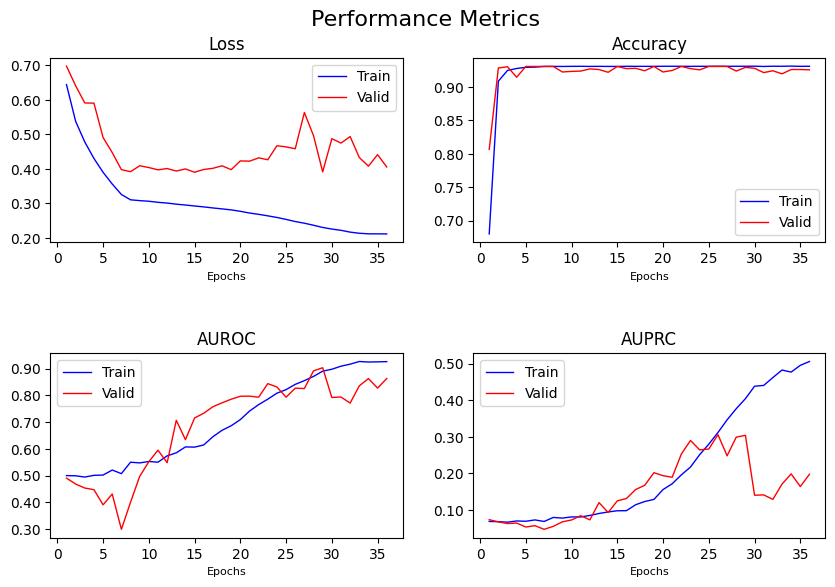

In [11]:
def plot_metric_subplot(train_metric, val_metric, metric_name, subplot_position):
    """
    서브플롯 위치에 성능 지표에 대한 그래프를 그립니다.
    :param train_metric: 훈련 데이터의 성능 지표
    :param val_metric: 검증 데이터의 성능 지표
    :param metric_name: 그래프에 표시할 성능 지표의 이름
    :param subplot_position: subplot의 위치 (예: 221, 222, 223, 224)
    """
    plt.subplot(subplot_position)
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'b-', label='Train', lw=1)
    plt.plot(epochs, val_metric, 'r-', label='Valid', lw=1)
    plt.title(metric_name, fontsize=12)
    plt.xlabel('Epochs', fontsize=8)



    # Y축 눈금을 소수점 두 자리 형식으로 설정
    ax = plt.gca()
    y_vals = ax.get_yticks()
    ax.yaxis.set_major_locator(FixedLocator(y_vals))
    ax.set_yticklabels(['{:.2f}'.format(y) for y in y_vals])

    plt.legend()



# 성능 지표를 파일에서 불러오는 함수
def load_metrics(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
        train_losses = [epoch_info['train_loss'] for epoch_info in data.values()]
        val_losses = [epoch_info['valid_loss'] for epoch_info in data.values()]
        train_accuracies = [epoch_info['train_accuracy'] for epoch_info in data.values()]
        val_accuracies = [epoch_info['valid_accuracy'] for epoch_info in data.values()]
        train_aurocs = [epoch_info['train_auroc'] for epoch_info in data.values()]
        val_aurocs = [epoch_info['valid_auroc'] for epoch_info in data.values()]
        train_auprcs = [epoch_info['train_auprc'] for epoch_info in data.values()]
        val_auprcs = [epoch_info['valid_auprc'] for epoch_info in data.values()]
        return train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_auprcs, val_auprcs

# 파일에서 성능 지표를 불러옵니다.
train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_auprcs, val_auprcs = load_metrics('model_info.json')



# 2x2 격자 형태로 그래프 그리기
plt.figure(figsize=(10, 6))  # 전체 그래프의 크기 설정
plt.suptitle('Performance Metrics', fontsize=16)

plot_metric_subplot(train_losses, val_losses, 'Loss', 221)
plot_metric_subplot(train_accuracies, val_accuracies, 'Accuracy', 222)
plot_metric_subplot(train_aurocs, val_aurocs, 'AUROC', 223)
plot_metric_subplot(train_auprcs, val_auprcs, 'AUPRC', 224)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.6)
plt.show()


# Test

In [10]:


# ROC 커브와 PRC 그리기
def plot_roc_and_prc(y_true, y_pred, data_name):
    # ROC 커브
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {data_name}')
    plt.legend(loc="lower right")

    # PRC
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label='PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {data_name}')
    plt.legend(loc="lower left")
    plt.show()

# Youden Index를 사용하여 최적의 임계값 찾기
def find_optimal_cutoff(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Confusion Matrix 시각화
def plot_confusion_matrix(y_true, y_pred, thresh, data_name):
    cm = confusion_matrix(y_true, y_pred > thresh)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {data_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


def test_model(model, test_loader, data_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    test_loss, test_preds, test_targets = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Testing {data_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs.view(-1), labels.float()).item()
            test_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            test_targets.extend(labels.cpu().numpy())

    optimal_threshold = find_optimal_cutoff(test_targets, test_preds)
    test_accuracy = accuracy_score(test_targets, np.array(test_preds) > optimal_threshold)
    test_loss /= len(test_loader)
    test_auroc = roc_auc_score(test_targets, test_preds)
    test_auprc = average_precision_score(test_targets, test_preds)

    print(f'[{data_name} Test] AUROC: {test_auroc:.4f} / AUPRC: {test_auprc:.4f} / Accuracy: {test_accuracy * 100:.2f}% / Loss: {test_loss:.4f}')
    plot_roc_and_prc(test_targets, test_preds, data_name)
    plot_confusion_matrix(test_targets, test_preds, optimal_threshold, data_name)


def test_datasets(model_class, model_filename):
    try:
        model = model_class()
        model.load_state_dict(torch.load(model_filename))

        # PTB 데이터셋 테스트
        _, _, ptb_test_loader = create_dataloaders()
        test_model(model, ptb_test_loader, "PTB")

        # SPH 데이터셋 테스트
        sph_test_loader = load_sph_data()
        test_model(model, sph_test_loader, "SPH")

    except Exception as e:
        print(f"Testing failed: {e}")

Testing PTB: 100%|██████████| 35/35 [00:00<00:00, 125.27it/s]


[PTB Test] AUROC: 0.5349 / AUPRC: 0.0747 / Accuracy: 89.45% / Loss: 0.6931


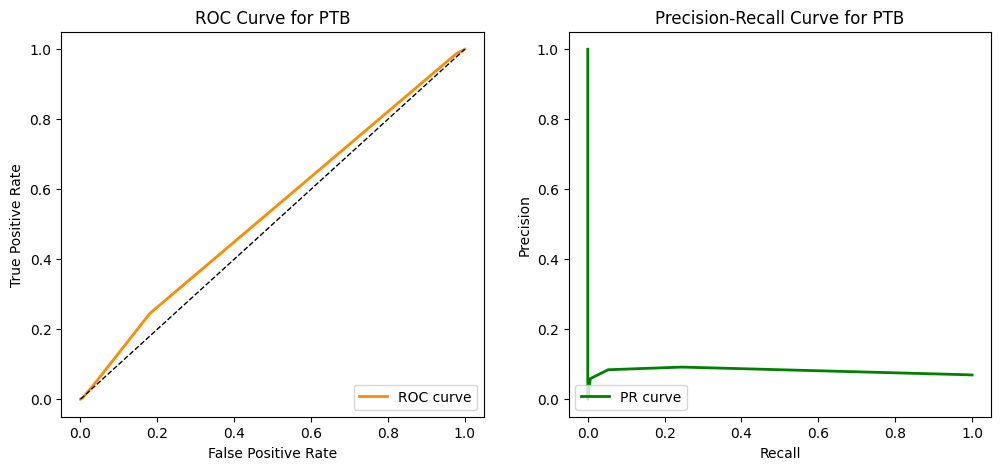

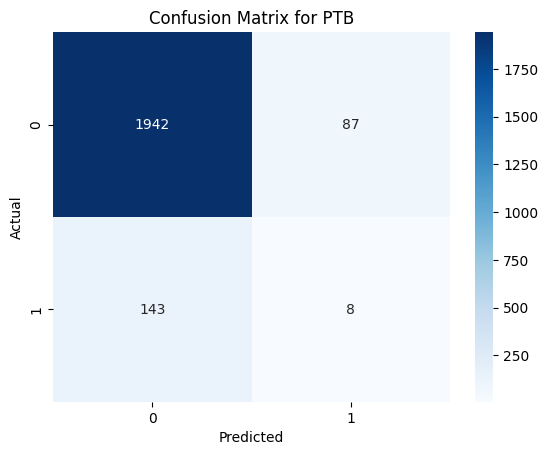

Testing SPH: 100%|██████████| 403/403 [00:03<00:00, 122.94it/s]


[SPH Test] AUROC: 0.4597 / AUPRC: 0.0239 / Accuracy: 97.38% / Loss: 0.6931


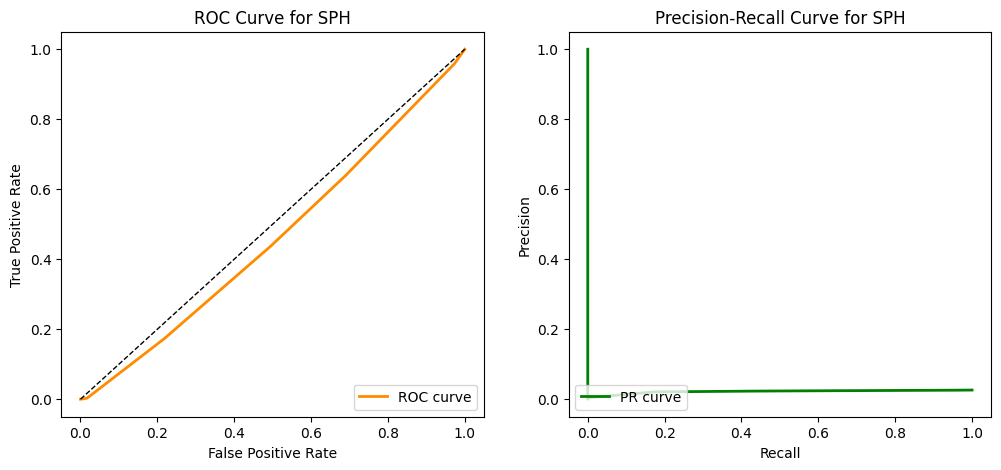

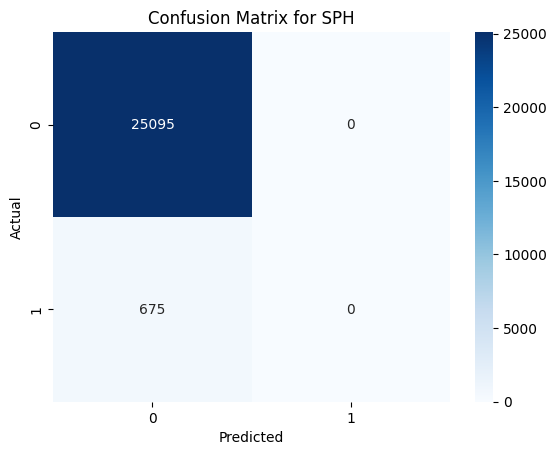

In [11]:
# 두 데이터셋을 함께 테스트
test_datasets(CNNLSTMModel, '/DATA/workspace/harbud/ecg/CL_trial_6_best_model.pth')